# Weak and strong scaling experiments 

In this notebook we perform weak and strong scaling experiemnts on the million songs dataset

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession as spark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import time
import re

In [8]:
def runExperiment(inputUri, outputUri, appName, numCores, perCores=2,):
    # fixed memory size
    sparkSession = SparkSession\
            .builder\
            .master('spark://192.168.2.25:7077') \
            .appName(appName)\
            .config("spark.executor.cores", 2)\
            .config("spark.executor.memory", "2g")\
            .config("spark.executor.instances", 8)\
            .config('spark.shuffle.service.enabled', False)\
            .config('spark.dynamicAllocation.executorIdleTimeout','30s')\
            .config('spark.cores.max', numCores)\
            .config('spark.driver.port',9998)\
            .config('spark.blockManager.port',10005)\
            .config('spark.mongodb.input.uri', inputUri)\
            .config('spark.mongodb.output.uri', outputUri)\
            .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
            .getOrCreate()
            # .config('spark.dynamicAllocation.enabled', True)\
            # .config('spark.dynamicAllocation.shuffleTracking.enabled',True)\    
    maxR = 0        
    for x in range(0, 10):
        t = time.time()
        df = sparkSession.read.format('com.mongodb.spark.sql.DefaultSource').load()
        d = time.time()
        read_time = d-t
        if maxR < read_time:
            maxR = read_time
        try:
            dfTest = df.select('_id','year','loudness','tempo','artist_hotttnesss','beats_confidence','duration','artist_latitude','artist_longitude','key_confidence')
            return [df, sparkSession, maxR]     
        except:
            str_error = True
            if str_error:
                time.sleep(2)
            else:
                break

In [15]:
def calculation(df, sparkSession):
    t = time.time()
    df = df.select('_id','year','loudness','tempo','artist_hotttnesss','beats_confidence','duration','artist_latitude','artist_longitude','key_confidence')
    df = df.withColumn('y_label', f.when(f.col('artist_hotttnesss') > 0.5, 1).otherwise(0))
    features = ['year', 'loudness', 'tempo', 'duration', 'key_confidence']
    label = 'y_label'

    assembler = VectorAssembler()\
        .setInputCols(features)\
        .setOutputCol('vectorized_features')
    df = assembler.transform(df)
    train, test = df.randomSplit([0.7, 0.3], seed = 2018)
    lr = LogisticRegression(featuresCol = 'vectorized_features', labelCol = 'y_label', maxIter=10)
    lrModel = lr.fit(train)
    sparkSession.stop()
    d = time.time()
    duration = d - t
    return duration

In [38]:
def printResults(results, labels, avgs, numIterations, title, xLable):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)

    xAxis = [int(re.sub("[^0-9]", "", cores)) for cores in labels]
    yAxis = [avg for avg in avgs]

    ax1.plot(xAxis,yAxis)
    ax1.set_title('Average run time (s) for 10 iterations per experiment')
    ax1.set_xticks(xAxis)
    ax1.set_ylim(0,np.max(yAxis)+10)
    ax1.set_xlabel(xLable)
    ax1.set_ylabel('Average run time (s)')

    xAxis = range(1,numIterations+1)

    for i, result in enumerate(results):
        ax2.plot(xAxis, result, label=labels[i])
        
    ax2.set_title('Run time (s) for each iterations per experiment')
    ax2.set_xticks(xAxis)
    ax2.set_ylim(0,np.max(yAxis)+10)
    plt.legend(loc="upper right")
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Run time (s)')
    
    plt.show()
    

# Strong Scaling with 1.5 million data

In [25]:
numIterations = 10

### 2 cores

In [26]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '2 cores'
numCores = 2

resultsStrong2 = []
readTime2 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsStrong2.append(d)
    readTime2.append(ls[2])
avgStrong2 = np.mean(resultsStrong2)
avgRead2 = np.mean(readTime2)
print(f'{resultsStrong2}, Avg: {avgStrong2}, read: {readTime2}, AvgRead:{avgRead2}')

[42.39041209220886, 45.670395851135254, 47.57003402709961, 45.324599504470825, 47.027427196502686, 42.514750719070435, 44.45056915283203, 45.642637968063354, 43.56487059593201, 41.07587432861328], Avg: 44.52315714359283, read: [5.569045782089233, 5.324380874633789, 5.4126386642456055, 5.663748025894165, 5.45369553565979, 5.474059820175171, 5.542708873748779, 5.349505662918091, 5.432183027267456, 5.4185731410980225], AvgRead:5.46405394077301


### 4 cores

In [28]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '4 cores'
numCores = 4

resultsStrong4 = []
readTime4 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsStrong4.append(d)
    readTime4.append(ls[2])
avgStrong4 = np.mean(resultsStrong4)
avgRead4 = np.mean(readTime4)
print(f'{resultsStrong4}, Avg: {avgStrong4}, read: {readTime4}, AvgRead:{avgRead4}')

[39.03291940689087, 37.00385332107544, 37.51628351211548, 32.068809270858765, 39.12580156326294, 40.607038736343384, 37.07480525970459, 36.61434602737427, 36.963688135147095, 39.44295954704285], Avg: 37.54505047798157, read: [5.445424556732178, 5.467613935470581, 5.471087694168091, 5.419313192367554, 5.377054929733276, 5.364708423614502, 5.401869773864746, 5.862964630126953, 5.523578643798828, 5.532857894897461], AvgRead:5.486647367477417


### 8 cores

In [29]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '8 cores'
numCores = 8

resultsStrong8 = []
readTime8 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsStrong8.append(d)
    readTime8.append(ls[2])
avgStrong8 = np.mean(resultsStrong8)
avgRead8 = np.mean(readTime8)
print(f'{resultsStrong8}, Avg: {avgStrong8}, read: {readTime8}, AvgRead:{avgRead8}')

[20.465531826019287, 19.553548097610474, 19.46295976638794, 17.55888032913208, 18.11235237121582, 19.625362873077393, 19.031458139419556, 17.606324195861816, 18.10027027130127, 17.52506947517395], Avg: 18.704175734519957, read: [5.467485189437866, 5.401735067367554, 5.495960712432861, 5.405186653137207, 5.342035293579102, 5.34757399559021, 5.41585636138916, 5.34704065322876, 5.359673023223877, 5.432665824890137], AvgRead:5.4015212774276735


### 12 cores

In [30]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '12 cores'
numCores = 12

resultsStrong12 = []
readTime12 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsStrong12.append(d)
    readTime12.append(ls[2])
avgStrong12 = np.mean(resultsStrong12)
avgRead12 = np.mean(readTime12)
print(f'{resultsStrong12}, Avg: {avgStrong12}, read: {readTime12}, AvgRead:{avgRead12}')

[20.04455327987671, 18.09826397895813, 18.945250034332275, 17.100141525268555, 19.112107753753662, 17.448698043823242, 20.567668199539185, 18.0887930393219, 19.420681476593018, 18.108078718185425], Avg: 18.69342360496521, read: [5.410864591598511, 5.361187934875488, 5.473623752593994, 5.354761362075806, 5.348747491836548, 5.517810583114624, 5.389926433563232, 5.35463809967041, 5.5358240604400635, 5.344064712524414], AvgRead:5.409144902229309


### 16 cores

In [31]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '16 cores'
numCores = 16

resultsStrong16 = []
readTime16 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsStrong16.append(d)
    readTime16.append(ls[2])
avgStrong16 = np.mean(resultsStrong16)
avgRead16 = np.mean(readTime16)
print(f'{resultsStrong16}, Avg: {avgStrong16}, read: {readTime16}, AvgRead:{avgRead16}')

[23.589093685150146, 20.307337999343872, 20.974509477615356, 22.6089026927948, 23.29285478591919, 23.629055976867676, 22.56933331489563, 24.393645763397217, 21.126171588897705, 23.181216955184937], Avg: 22.567212224006653, read: [5.041904926300049, 5.647277593612671, 5.973412990570068, 5.156405448913574, 5.1388468742370605, 5.103012561798096, 5.1967551708221436, 5.357166528701782, 5.121126413345337, 5.04721999168396], AvgRead:5.278312849998474


### Print results from all experiments

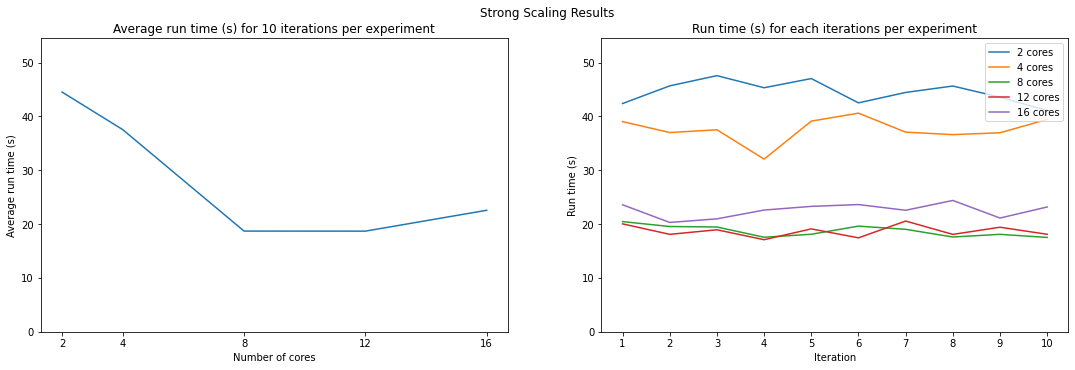

In [32]:
printResults([resultsStrong2, resultsStrong4, resultsStrong8, resultsStrong12, resultsStrong16],
             ['2 cores', '4 cores', '8 cores', '12 cores', '16 cores'],
             [avgStrong2, avgStrong4, avgStrong8, avgStrong12, avgStrong16], numIterations, "Strong Scaling Results","Number of cores")

# Weak Scaling

In [5]:
numIterations = 10

### 250000 songs, 2 cores

In [12]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsQuarterM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsQuarterM'
appName = '250000 data for 2 cores'
numCores = 2

resultsWeak2 = []
readTime2 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsWeak2.append(d)
    readTime2.append(ls[2])
avgWeak2 = np.mean(resultsWeak2)
avgRead2 = np.mean(readTime2)
print(f'{resultsWeak2}, Avg: {avgWeak2}, read: {readTime2}, AvgRead:{avgRead2}')

[16.86281418800354, 11.94393515586853, 12.01013970375061, 14.364813566207886, 13.590304613113403, 13.304442405700684, 13.84395694732666, 14.8650963306427, 13.980656385421753, 12.545405626296997], Avg: 13.731156492233277, read: [5.597989797592163, 5.505635499954224, 5.425630331039429, 5.591029167175293, 5.36031699180603, 5.658090114593506, 5.607220649719238, 5.6023876667022705, 5.471487998962402, 5.407009840011597], AvgRead:5.522679805755615


### 500000 songs, 4 cores

In [13]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsHalfM'
appName = '500000 data for 4 cores'
numCores = 4

resultsWeak4 = []
readTime4 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsWeak4.append(d)
    readTime4.append(ls[2])
avgWeak4 = np.mean(resultsWeak4)
avgRead4 = np.mean(readTime4)
print(f'{resultsWeak4}, Avg: {avgWeak4}, read: {readTime4}, AvgRead:{avgRead4}')

[22.777233362197876, 17.318232536315918, 16.779757261276245, 15.25444221496582, 17.82337999343872, 18.910868406295776, 18.38833713531494, 17.997560739517212, 16.825274229049683, 18.447253465652466], Avg: 18.052233934402466, read: [5.683746814727783, 5.646724224090576, 5.6820878982543945, 5.691142797470093, 5.638810634613037, 5.554732799530029, 5.570666313171387, 5.4597132205963135, 5.6360390186309814, 5.51181173324585], AvgRead:5.607547545433045


### 1000000 songs, 8 cores

In [14]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOneM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOneM'
appName = '1000000 data for 8 cores'
numCores = 8

resultsWeak8 = []
readTime8 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsWeak8.append(d)
    readTime8.append(ls[2])
avgWeak8 = np.mean(resultsWeak8)
avgRead8 = np.mean(readTime8)
print(f'{resultsWeak8}, Avg: {avgWeak8}, read: {readTime8}, AvgRead:{avgRead8}')

[25.795995712280273, 20.835158824920654, 21.881702184677124, 21.414695501327515, 18.951730728149414, 20.980191707611084, 19.433016300201416, 22.39866852760315, 18.837317943572998, 21.367242097854614], Avg: 21.189571952819826, read: [9.168370246887207, 5.6322619915008545, 5.567492961883545, 5.556224346160889, 5.513872385025024, 5.448964595794678, 5.513646364212036, 5.557996034622192, 5.632232189178467, 5.59250283241272], AvgRead:5.918356394767761


### 1500000 songs, 12 cores

In [15]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '1500000 data for 12 cores'
numCores = 12

resultsWeak12 = []
readTime12 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsWeak12.append(d)
    readTime12.append(ls[2])
avgWeak12 = np.mean(resultsWeak12)
avgRead12 = np.mean(readTime12)
print(f'{resultsWeak12}, Avg: {avgWeak12}, read: {readTime12}, AvgRead:{avgRead12}')

22/03/20 07:40:32 WARN NioEventLoop: Selector.select() returned prematurely 512 times in a row; rebuilding Selector io.netty.channel.nio.SelectedSelectionKeySetSelector@600444d8.


[21.77092719078064, 20.623175859451294, 20.041709661483765, 20.65014958381653, 22.086599826812744, 19.00388813018799, 17.82561492919922, 16.987247467041016, 23.046247005462646, 17.583856105804443], Avg: 19.96194157600403, read: [9.190235137939453, 5.338489532470703, 5.414072275161743, 5.31352686882019, 5.382806062698364, 5.457095146179199, 6.126831293106079, 5.473518371582031, 5.3966991901397705, 5.367822885513306], AvgRead:5.846109676361084


### Results

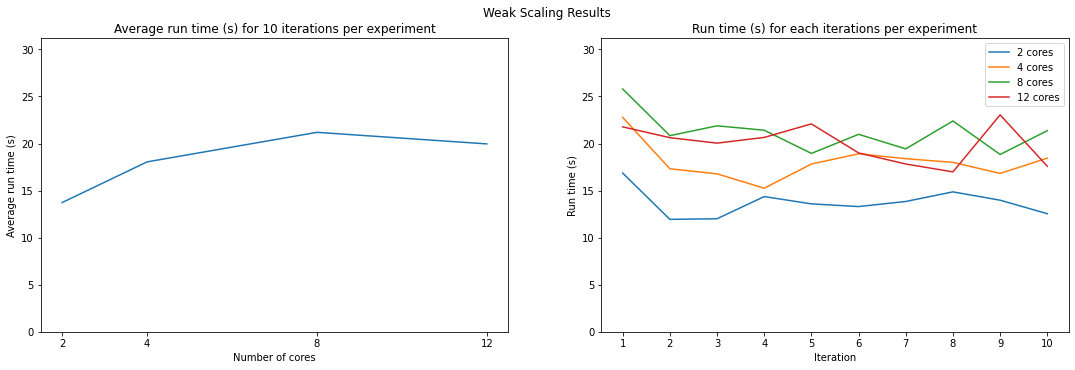

In [35]:
resultsWeak2 = [16.86281418800354, 11.94393515586853, 12.01013970375061, 14.364813566207886, 13.590304613113403, 13.304442405700684, 13.84395694732666, 14.8650963306427, 13.980656385421753, 12.545405626296997]
avgWeak2 = 13.731156492233277
resultsWeak4 = [22.777233362197876, 17.318232536315918, 16.779757261276245, 15.25444221496582, 17.82337999343872, 18.910868406295776, 18.38833713531494, 17.997560739517212, 16.825274229049683, 18.447253465652466]
avgWeak4 = 18.052233934402466
resultsWeak8 = [25.795995712280273, 20.835158824920654, 21.881702184677124, 21.414695501327515, 18.951730728149414, 20.980191707611084, 19.433016300201416, 22.39866852760315, 18.837317943572998, 21.367242097854614]
avgWeak8 = 21.189571952819826
resultsWeak12 = [21.77092719078064, 20.623175859451294, 20.041709661483765, 20.65014958381653, 22.086599826812744, 19.00388813018799, 17.82561492919922, 16.987247467041016, 23.046247005462646, 17.583856105804443]
avgWeak12 = 19.96194157600403

printResults([resultsWeak2, resultsWeak4, resultsWeak8, resultsWeak12],
             ['2 cores', '4 cores', '8 cores', '12 cores'],
             [avgWeak2, avgWeak4, avgWeak8, avgWeak12], numIterations, "Weak Scaling Results", "Number of cores")

# Horizontal scaling

In [6]:
numIterations = 10

### 4 workers

In [20]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '4 workers'
numCores = 12

resultsW4 = []
readT4 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    t = time.time()
    d = calculation(ls[0], ls[1])
    resultsW4.append(d)
    readT4.append(ls[2])
avgW4 = np.mean(resultsW4)
avgR4 = np.mean(readT4)
print(f'{resultsW4}, Avg: {avgW4}, read: {readT4}, AvgRead:{avgR4}')

22/03/20 08:51:13 WARN NioEventLoop: Selector.select() returned prematurely 512 times in a row; rebuilding Selector io.netty.channel.nio.SelectedSelectionKeySetSelector@4b4d7bde.


[22.30652141571045, 21.538985013961792, 21.52507185935974, 20.62351107597351, 19.898587226867676, 23.068907022476196, 21.204931020736694, 24.00457000732422, 21.65461492538452, 21.78132939338684], Avg: 21.760702896118165, read: [5.2953948974609375, 5.186372995376587, 5.048182964324951, 5.061849355697632, 5.296099424362183, 5.896594524383545, 5.019148349761963, 5.176033973693848, 5.025819540023804, 5.209441900253296], AvgRead:5.221493792533875


### 5 workers

In [9]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '5 workers'
numCores = 14

resultsW5 = []
readT5 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsW5.append(d)
    readT5.append(ls[2])
avgW5 = np.mean(resultsW5)
avgR5 = np.mean(readT5)
print(f'{resultsW5}, Avg: {avgW5}, read: {readT5}, AvgRead:{avgR5}')

[20.71346926689148, 22.594167709350586, 21.160473585128784, 22.33843207359314, 20.30896806716919, 20.68993330001831, 22.078088760375977, 21.631627082824707, 20.828859090805054, 21.029708862304688], Avg: 21.33737277984619, read: [5.305450916290283, 5.832362651824951, 5.023281097412109, 5.22426176071167, 5.1512839794158936, 5.033323287963867, 4.967853784561157, 5.8576624393463135, 4.997884511947632, 5.1849892139434814], AvgRead:5.2578353643417355


### 6 workers

In [17]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '6 workers'
numCores = 16

resultsW6 = []
readT6 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    d = calculation(ls[0], ls[1])
    resultsW6.append(d)
    readT6.append(ls[2])
avgW6 = np.mean(resultsW6)
avgR6 = np.mean(readT6)
print(f'{resultsW6}, Avg: {avgW6}, read: {readT6}, AvgRead:{avgR6}')

[21.266408920288086, 23.37617826461792, 20.747185707092285, 21.288980960845947, 21.70623016357422, 21.287323236465454, 21.50190758705139, 22.570557117462158, 21.61768674850464, 20.601430416107178], Avg: 21.59638891220093, read: [5.1439268589019775, 5.60527777671814, 4.93609881401062, 5.196144104003906, 5.054734706878662, 5.0379955768585205, 5.203981161117554, 5.162667989730835, 5.100900173187256, 5.869917869567871], AvgRead:5.231164503097534


### Result

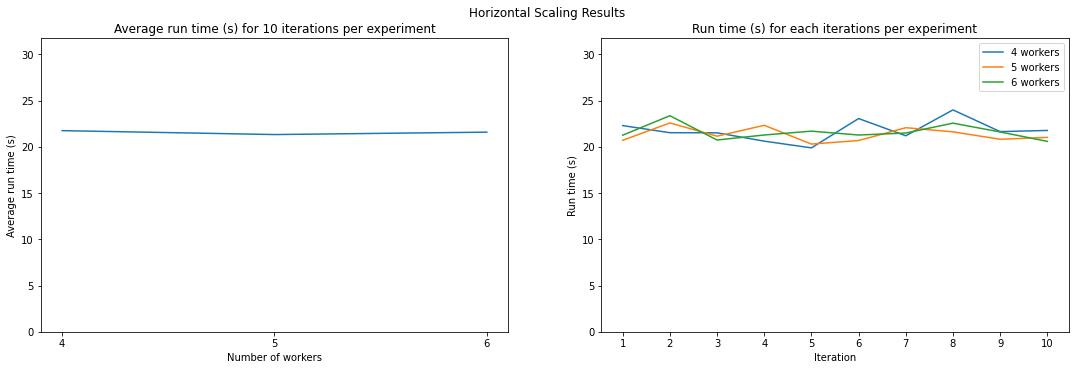

In [39]:
resultsW4 = [22.30652141571045, 21.538985013961792, 21.52507185935974, 20.62351107597351, 19.898587226867676, 23.068907022476196, 21.204931020736694, 24.00457000732422, 21.65461492538452, 21.78132939338684]
avgW4 = 21.760702896118165

resultsW5 = [20.71346926689148, 22.594167709350586, 21.160473585128784, 22.33843207359314, 20.30896806716919, 20.68993330001831, 22.078088760375977, 21.631627082824707, 20.828859090805054, 21.029708862304688] 
avgW5 = 21.33737277984619

resultsW6 = [21.266408920288086, 23.37617826461792, 20.747185707092285, 21.288980960845947, 21.70623016357422, 21.287323236465454, 21.50190758705139, 22.570557117462158, 21.61768674850464, 20.601430416107178]
avgW6 = 21.59638891220093
printResults([resultsW4, resultsW5, resultsW6],
             ['4 workers', '5 workers', '6 workers'],
             [avgW4, avgW5, avgW6], numIterations, "Horizontal Scaling Results", "Number of workers")

# more complicated calculation for testing horizontal scaling

In [10]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
def calculationMore(df, sparkSession):
    t = time.time()
    df = df.select('_id','year','loudness','tempo','artist_hotttnesss','beats_confidence','duration','artist_latitude','artist_longitude','key_confidence')
    df = df.withColumn('label', f.when(f.col('artist_hotttnesss') > 0.5, 1).otherwise(0))
    features = ['year', 'loudness', 'tempo', 'duration', 'key_confidence']
    label = 'label'

    assembler = VectorAssembler()\
        .setInputCols(features)\
        .setOutputCol('vectorized_features')
    df = assembler.transform(df)
    train, test = df.randomSplit([0.7, 0.3], seed = 2018)
    lr = LogisticRegression(featuresCol = 'vectorized_features', labelCol = 'label')
    grid = (ParamGridBuilder().addGrid(lr.maxIter, [1, 5, 10]).build())
    evaluator = BinaryClassificationEvaluator()
    cv = CrossValidator(estimator=lr,
                        estimatorParamMaps=grid,
                        evaluator=evaluator,
                        numFolds = 3)
    cvModel = cv.fit(train)
    # lrModel = lr.fit(train)
    sparkSession.stop()
    d = time.time()
    duration = d - t
    return duration

### 4 workers 

In [11]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '4 workers'
numCores = 12

resultsW4 = []
readT4 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    t = time.time()
    d = calculationMore(ls[0], ls[1])
    resultsW4.append(d)
    readT4.append(ls[2])
avgW4 = np.mean(resultsW4)
avgR4 = np.mean(readT4)
print(f'{resultsW4}, Avg: {avgW4}, read: {readT4}, AvgRead:{avgR4}')

22/03/20 10:14:08 WARN Dispatcher: Message RemoteProcessDisconnected(192.168.2.28:48560) dropped. Could not find BlockManagerEndpoint3.
22/03/20 10:16:19 ERROR TaskSchedulerImpl: Lost executor 4 on 192.168.2.133: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/03/20 10:16:19 WARN TaskSetManager: Lost task 11.0 in stage 50.0 (TID 986) (192.168.2.133 executor 4): ExecutorLostFailure (executor 4 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/03/20 10:16:19 WARN TaskSetManager: Lost task 5.0 in stage 50.0 (TID 980) (192.168.2.133 executor 4): ExecutorLostFailure (executor 4 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22

Py4JJavaError: An error occurred while calling o10326.fit.
: com.mongodb.MongoCommandException: Command failed with error 133 (FailedToSatisfyReadPreference): 'Could not find host matching read preference { mode: "primary" } for set shard4' on server 127.0.0.1:27017. The full response is {"ok": 0.0, "errmsg": "Could not find host matching read preference { mode: \"primary\" } for set shard4", "code": 133, "codeName": "FailedToSatisfyReadPreference", "$clusterTime": {"clusterTime": {"$timestamp": {"t": 1647771485, "i": 1}}, "signature": {"hash": {"$binary": "AAAAAAAAAAAAAAAAAAAAAAAAAAA=", "$type": "00"}, "keyId": {"$numberLong": "0"}}}, "operationTime": {"$timestamp": {"t": 1647771485, "i": 1}}}
	at com.mongodb.internal.connection.ProtocolHelper.getCommandFailureException(ProtocolHelper.java:175)
	at com.mongodb.internal.connection.InternalStreamConnection.receiveCommandMessageResponse(InternalStreamConnection.java:303)
	at com.mongodb.internal.connection.InternalStreamConnection.sendAndReceive(InternalStreamConnection.java:259)
	at com.mongodb.internal.connection.UsageTrackingInternalConnection.sendAndReceive(UsageTrackingInternalConnection.java:99)
	at com.mongodb.internal.connection.DefaultConnectionPool$PooledConnection.sendAndReceive(DefaultConnectionPool.java:450)
	at com.mongodb.internal.connection.CommandProtocolImpl.execute(CommandProtocolImpl.java:72)
	at com.mongodb.internal.connection.DefaultServer$DefaultServerProtocolExecutor.execute(DefaultServer.java:226)
	at com.mongodb.internal.connection.DefaultServerConnection.executeProtocol(DefaultServerConnection.java:269)
	at com.mongodb.internal.connection.DefaultServerConnection.command(DefaultServerConnection.java:131)
	at com.mongodb.internal.connection.DefaultServerConnection.command(DefaultServerConnection.java:123)
	at com.mongodb.operation.CommandOperationHelper.executeCommand(CommandOperationHelper.java:343)
	at com.mongodb.operation.CommandOperationHelper.executeCommand(CommandOperationHelper.java:334)
	at com.mongodb.operation.CommandOperationHelper.executeCommandWithConnection(CommandOperationHelper.java:220)
	at com.mongodb.operation.CommandOperationHelper$5.call(CommandOperationHelper.java:206)
	at com.mongodb.operation.OperationHelper.withReadConnectionSource(OperationHelper.java:463)
	at com.mongodb.operation.CommandOperationHelper.executeCommand(CommandOperationHelper.java:203)
	at com.mongodb.operation.CommandOperationHelper.executeCommand(CommandOperationHelper.java:198)
	at com.mongodb.operation.CommandReadOperation.execute(CommandReadOperation.java:59)
	at com.mongodb.client.internal.MongoClientDelegate$DelegateOperationExecutor.execute(MongoClientDelegate.java:196)
	at com.mongodb.client.internal.MongoDatabaseImpl.executeCommand(MongoDatabaseImpl.java:194)
	at com.mongodb.client.internal.MongoDatabaseImpl.runCommand(MongoDatabaseImpl.java:163)
	at com.mongodb.spark.rdd.partitioner.PartitionerHelper$.$anonfun$collStats$1(PartitionerHelper.scala:103)
	at com.mongodb.spark.MongoConnector.$anonfun$withDatabaseDo$1(MongoConnector.scala:174)
	at com.mongodb.spark.MongoConnector.withMongoClientDo(MongoConnector.scala:157)
	at com.mongodb.spark.MongoConnector.withDatabaseDo(MongoConnector.scala:174)
	at com.mongodb.spark.rdd.partitioner.PartitionerHelper$.collStats(PartitionerHelper.scala:103)
	at com.mongodb.spark.rdd.partitioner.MongoSamplePartitioner.$anonfun$partitions$1(MongoSamplePartitioner.scala:77)
	at scala.util.Try$.apply(Try.scala:213)
	at com.mongodb.spark.rdd.partitioner.MongoSamplePartitioner.partitions(MongoSamplePartitioner.scala:77)
	at com.mongodb.spark.rdd.partitioner.DefaultMongoPartitioner.partitions(DefaultMongoPartitioner.scala:34)
	at com.mongodb.spark.rdd.MongoRDD.getPartitions(MongoRDD.scala:135)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.sql.execution.SQLExecutionRDD.getPartitions(SQLExecutionRDD.scala:44)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:300)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:296)
	at org.apache.spark.ml.util.Instrumentation.$anonfun$logDataset$1(Instrumentation.scala:68)
	at org.apache.spark.ml.util.Instrumentation.$anonfun$logInfo$1(Instrumentation.scala:97)
	at org.apache.spark.internal.Logging.logInfo(Logging.scala:57)
	at org.apache.spark.internal.Logging.logInfo$(Logging.scala:56)
	at org.apache.spark.ml.util.Instrumentation.logInfo(Instrumentation.scala:97)
	at org.apache.spark.ml.util.Instrumentation.logDataset(Instrumentation.scala:68)
	at org.apache.spark.ml.util.Instrumentation.logDataset(Instrumentation.scala:62)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:497)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:495)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:286)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at sun.reflect.GeneratedMethodAccessor107.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)


22/03/20 10:18:26 WARN MongoSamplePartitioner: Could not get collection statistics. Server errmsg: Command failed with error 133 (FailedToSatisfyReadPreference): 'Could not find host matching read preference { mode: "primary" } for set shard4' on server 127.0.0.1:27017. The full response is {"ok": 0.0, "errmsg": "Could not find host matching read preference { mode: \"primary\" } for set shard4", "code": 133, "codeName": "FailedToSatisfyReadPreference", "$clusterTime": {"clusterTime": {"$timestamp": {"t": 1647771505, "i": 2}}, "signature": {"hash": {"$binary": "AAAAAAAAAAAAAAAAAAAAAAAAAAA=", "$type": "00"}, "keyId": {"$numberLong": "0"}}}, "operationTime": {"$timestamp": {"t": 1647771505, "i": 2}}}
22/03/20 10:18:26 ERROR MongoRDD: 
-----------------------------
-----------------------------

Partitioning using the 'DefaultMongoPartitioner$' failed.

Please check the stacktrace to determine the cause of the failure or check the Partitioner API documentation.
Note: Not all partitioners a

## 5 workers

In [ ]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '5 workers'
numCores = 14

resultsW5 = []
readT5 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    t = time.time()
    d = calculationMore(ls[0], ls[1])
    resultsW5.append(d)
    readT5.append(ls[2])
avgW5 = np.mean(resultsW5)
avgR5 = np.mean(readT5)
print(f'{resultsW5}, Avg: {avgW5}, read: {readT5}, AvgRead:{avgR5}')

## 6 workers

In [ ]:
inputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
outputUri = 'mongodb://127.0.0.1/million_songs.songsOHalfM'
appName = '6 workers'
numCores = 16

resultsW6 = []
readT6 = []

for i in range(numIterations):
    ls = runExperiment(inputUri, outputUri, appName, numCores)
    t = time.time()
    d = calculationMore(ls[0], ls[1])
    resultsW6.append(d)
    readT6.append(ls[2])
avgW6 = np.mean(resultsW6)
avgR6 = np.mean(readT6)
print(f'{resultsW6}, Avg: {avgW6}, read: {readT6}, AvgRead:{avgR6}')

## Results

In [ ]:
printResults([resultsW4, resultsW5, resultsW6],
             ['4 workers', '5 workers', '6 workers'],
             [avgW4, avgW5, avgW6], numIterations, "Horizontal Scaling Results", "Number of workers")